#PCA 

Principal component analysis (PCA) is a statistical analysis technique that transforms possibly correlated variables to orthogonal linearly uncorrelated values. We can use it for applications such as data compression, to get dominant physical processes and to get important features for machine learning. Without losing much information, it reduces the number of features in the original data.

Recently, I was using PCA with Spark with sparse matrix with millions of rows and to make sure everything was right I first started with a small dataset and compared the results from Spark, Python and R which led to this blog post.

In this post, I will cover data prepocessing required and how to implement PCA in R, Python and Spark and how to translate the results.

The calculation is done using singular value decomposition (SVD). The SVD of any m x n matrix is calculated as

A=U∑VT 
where U is an m × m orthogonal matrix whose columns are the eigenvectors of  AAT  , V is an n × n orthogonal matrix whose columns are the eigenvectors of  ATA , and Σ is an m × n diagonal matrix and its values are zero except along the diagonal.

When applying PCA, we have to center our data that is we have to subtract the column mean. Next, based on the nature of our data, we may need to standardize our data (make each feature have a unit variance and zero mean). If the columns are in different scales such as year, temperature, carbondioxide concentration, for example, we have to standardize the data. If the data is in the same unit, on the other hand, standardizing it can result in loss of important information. In the first case, when the columns are in the same unit and in similar scale, we use the covariance matrix for SVD but when the units are different since we standardize the data, we use the correlation matrix.

The principal components (PCs) are the matrix product of the original data and the matrix V which is equal to the product of matrixes U and ∑.

In [0]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import scale
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/venky14/Machine-Learning-with-Iris-Dataset/master/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [0]:
df = df.drop(['Id','Species'], axis = 1)

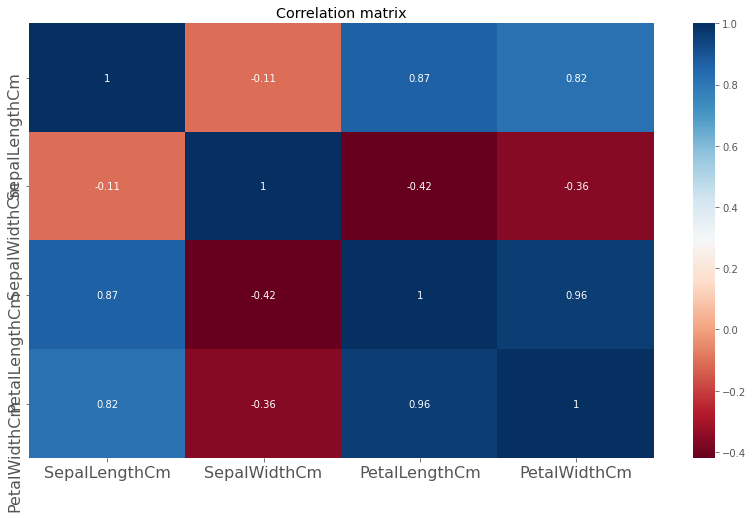

In [0]:
corr = df.corr()
plt.figure(figsize = (14, 8))
sns.heatmap(corr, cmap="RdBu",annot = True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation matrix')
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.show()

#Center

In [0]:
scaled = scale(df, with_mean=True, with_std=False)

#PCA

In [0]:
model = PCA()
model.fit(scaled)
transformed = model.transform(scaled)

In [0]:
np.round(model.explained_variance_ratio_ * 100,4)

array([92.4616,  5.3016,  1.7185,  0.5183])

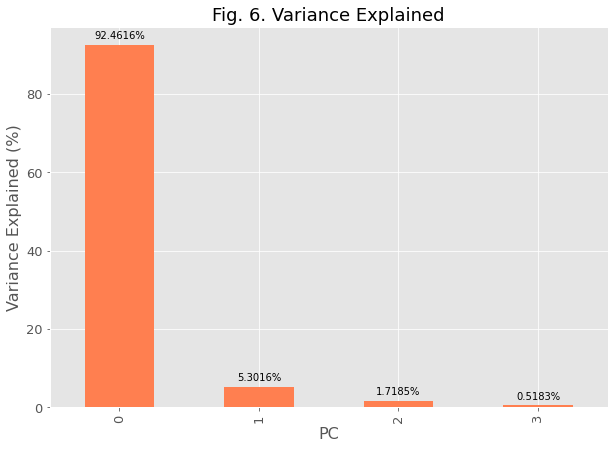

In [0]:
var = pd.DataFrame ({'variance':np.round(model.explained_variance_ratio_ * 100,4), 
                    'PC':['p' + str(i) for i in range(1,5)]})

ax = var.plot(kind='bar', figsize=(10,7), color="coral", fontsize=13, legend = False)
ax.set_alpha(0.8)
ax.set_title("Fig. 6. Variance Explained", fontsize=18)
ax.set_xlabel("PC", fontsize=16)
ax.set_ylabel("Variance Explained (%)", fontsize=16)

rects = ax.patches
labels = list(var['variance'])
labels = [str(variance) +'%' for variance in labels]
                          

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha ='center', va='bottom')

In [0]:
loadings = np.round(model.components_,4)
loadings

array([[ 0.3616, -0.0823,  0.8566,  0.3588],
       [ 0.6565,  0.7297, -0.1758, -0.0747],
       [-0.581 ,  0.5964,  0.0725,  0.5491],
       [ 0.3173, -0.3241, -0.4797,  0.7511]])

In [0]:
np.set_printoptions(suppress=True)
transformed = np.round(transformed, 5)
transformed[:10,:]

array([[-2.68421,  0.32661, -0.02151,  0.00101],
       [-2.71539, -0.16956, -0.20352,  0.0996 ],
       [-2.88982, -0.13735,  0.02471,  0.0193 ],
       [-2.74644, -0.31112,  0.03767, -0.07596],
       [-2.72859,  0.33392,  0.09623, -0.06313],
       [-2.2799 ,  0.74778,  0.17433, -0.02715],
       [-2.82089, -0.0821 ,  0.26425, -0.0501 ],
       [-2.62648,  0.17041, -0.0158 , -0.04628],
       [-2.88796, -0.5708 ,  0.02734, -0.02662],
       [-2.67384, -0.10669, -0.19153, -0.05589]])

In [0]:
np.round(np.corrcoef(transformed, rowvar=False),5)

array([[ 1.,  0.,  0., -0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.],
       [-0.,  0., -0.,  1.]])

In [12]:
df = pd.read_csv('https://courses.edx.org/asset-v1:MITx+15.071x_2a+2T2015+type@asset+block/climate_change.csv')
df.head()

,Year,Month,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols,Temp
0,1983,5,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863,0.109
1,1983,6,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794,0.118
2,1983,7,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731,0.137
3,1983,8,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673,0.176
4,1983,9,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619,0.149


In [0]:
df = df.drop('Temp', axis = 1)

In [14]:
scaled = scale(df, with_mean=True, with_std=True)
scaled[:10,:]

array([[-1.70855544, -0.45093617,  2.43534589, -1.3674928 , -2.41935872,
        -1.67058335, -3.00259074, -2.55333892,  0.07930841,  2.40128134],
       [-1.70855544, -0.16037479,  2.01992275, -1.40233993, -2.52549908,
        -1.65735645, -2.96630166, -2.52328676,  0.12542829,  2.16336977],
       [-1.70855544,  0.13018659,  1.56498635, -1.51084122, -2.53615661,
        -1.64796344, -2.92862636, -2.490775  ,  0.53699806,  1.94614617],
       [-1.70855544,  0.42074798,  0.91248367, -1.66131748, -2.57682925,
        -1.63952889, -2.88981239, -2.45772628,  0.87587889,  1.74616253],
       [-1.70855544,  0.71130936,  0.16279974, -1.82604937, -2.20599051,
        -1.62764385, -2.85070138, -2.42599396,  0.40791253,  1.55997087],
       [-1.70855544,  1.00187074, -0.29213666, -1.81575363, -1.87125689,
        -1.61441695, -2.81213495, -2.39639215, -0.02972499,  1.38757118],
       [-1.70855544,  1.29243213, -0.48222745, -1.71834006, -1.9921873 ,
        -1.60253191, -2.77500423, -2.36895547

In [0]:
model = PCA()
model.fit(scaled)
transformed = model.transform(scaled)

In [16]:
np.round(model.explained_variance_ratio_ * 100,4)

array([51.9871, 14.6612, 10.8331, 10.1167,  6.2387,  5.4798,  0.4623,
        0.1489,  0.0639,  0.0084])

In [17]:
np.round(model.components_,4)

array([[-0.4237,  0.011 ,  0.0697, -0.4128, -0.4262, -0.417 , -0.2862,
        -0.4192, -0.0591,  0.1687],
       [-0.1014, -0.0091,  0.5125, -0.1341,  0.092 , -0.1201,  0.4596,
         0.1951,  0.3811,  0.54  ],
       [-0.127 , -0.0696, -0.5834, -0.1264, -0.0107, -0.1153,  0.138 ,
         0.0093,  0.748 , -0.1751],
       [-0.0212,  0.9886, -0.0822, -0.0971,  0.0492,  0.014 ,  0.0466,
         0.0357,  0.0033,  0.0065],
       [ 0.2036,  0.0319, -0.21  ,  0.2475, -0.0282,  0.2715, -0.4918,
        -0.1428,  0.2102,  0.6865],
       [-0.0916, -0.0906, -0.5833, -0.1322,  0.087 , -0.1342,  0.3956,
         0.1381, -0.4968,  0.4215],
       [ 0.1556,  0.054 , -0.0286,  0.3007, -0.8778,  0.0796,  0.2781,
         0.1653,  0.0059, -0.0015],
       [-0.3187,  0.07  ,  0.001 ,  0.7632,  0.1638, -0.3456,  0.1735,
        -0.3669,  0.0053,  0.0063],
       [-0.0458, -0.0181,  0.0099, -0.1558, -0.0077,  0.603 ,  0.4   ,
        -0.6702, -0.0046, -0.0166],
       [ 0.7848,  0.018 ,  0.0003, -0

In [18]:
transformed = np.round(transformed, 5)
transformed[:10,:6]

array([[ 5.51092,  1.03562, -1.58056, -0.83435,  1.90866, -1.59633],
       [ 5.47343,  0.72501, -1.27296, -0.51325,  1.82735, -1.49142],
       [ 5.40493,  0.56482, -0.66364, -0.17564,  1.82238, -1.51685],
       [ 5.35984,  0.28859,  0.00946,  0.18075,  1.84502, -1.38006],
       [ 5.18755, -0.29822,  0.13036,  0.56422,  1.71375, -0.74276],
       [ 4.97996, -0.74257,  0.07758,  0.9048 ,  1.58169, -0.31363],
       [ 4.92081, -0.88351,  0.27896,  1.19451,  1.55837, -0.36115],
       [ 4.87075, -1.00623,  0.18382,  1.46706,  1.46812, -0.39278],
       [ 4.7437 , -1.73554, -0.6854 , -1.68736,  1.01412,  0.73762],
       [ 4.65483, -1.7006 , -0.106  , -1.38536,  1.11894,  0.5066 ]])

In [19]:
np.round(np.corrcoef(transformed, rowvar=False), 4)

array([[ 1.,  0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  1., -0., -0., -0.,  0.,  0.,  0.,  0., -0.],
       [ 0., -0.,  1., -0.,  0., -0.,  0., -0., -0., -0.],
       [-0., -0., -0.,  1., -0.,  0.,  0., -0., -0.,  0.],
       [-0., -0.,  0., -0.,  1., -0., -0.,  0., -0.,  0.],
       [-0.,  0., -0.,  0., -0.,  1., -0., -0.,  0., -0.],
       [ 0.,  0.,  0.,  0., -0., -0.,  1.,  0., -0.,  0.],
       [-0.,  0., -0., -0.,  0., -0.,  0.,  1., -0., -0.],
       [ 0.,  0., -0., -0., -0.,  0., -0., -0.,  1.,  0.],
       [ 0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  1.]])